<a href="https://colab.research.google.com/github/uhalpern/nutrition-data-analysis/blob/main/Tasi_EDA_dataset_creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nutrition Dataset EDA

Team: Data Minions

Authors: Urban Halpern, Ameya Padole, Vedang Gharat

## Setting Up Environment

In [ ]:
%%capture
!pip install faiss-cpu sentence-transformers datasets

In [ ]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

## Load Data into Pandas Dataframe

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gokulprasantht/nutrition-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.08M/3.08M [00:00<00:00, 153MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gokulprasantht/nutrition-dataset/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/gokulprasantht/nutrition-dataset/versions/1

nutrition.xlsx


In [ ]:
file_path = "/root/.cache/kagglehub/datasets/gokulprasantht/nutrition-dataset/versions/1"

In [ ]:
data = pd.read_excel(file_path + "/nutrition.xlsx")

## Creating Categories Using FAISS K-Nearest Neighbors

In [ ]:
categories = ["Vegetables", "Red Meat", "Poultry", "Dairy", "Grains", "Snacks", "Beverages", "Condiments", "Seafood", "Eggs", "Sauce", "Oil", "Legumes and seeds", "Miscellaneous Ingredients", "Fruits"]

In [ ]:
encoding_model = SentenceTransformer("dunzhang/stella_en_1.5B_v5", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/169k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

modeling_qwen.py:   0%|          | 0.00/65.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_1.5B_v5:
- modeling_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

tokenization_qwen.py:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_1.5B_v5:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

2_Dense_1024/config.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

In [ ]:
# Create embeddings for the categorories
embeddings = encoding_model.encode(categories)
embeddings = np.array(embeddings, dtype="float32")
embeddings[0][0] # get the first vector magnitude of the first encoding

-5.757954

We will normalize the embeddings so that cosine-similarity can be used to search for nearest neighbors

In [ ]:
# Calculate L2 norm before normalization
norm_before = np.linalg.norm(embeddings[0])
print("L2 norm before normalization:", norm_before)

# Normalize the embeddings
faiss.normalize_L2(embeddings)

# Calculate L2 norm after normalization
norm_after = np.linalg.norm(embeddings[0])
print("L2 norm after normalization:", norm_after)

L2 norm before normalization: 74.59635
L2 norm after normalization: 1.0000001


The L2 norm gives us the magnitude of each vector. This is calculated by the following formula:

$$ \text{L2 Norm} = \sqrt{∑_{i=1}^{n}x_{i}^{2}}$$

Which is the square root sum of squares of the vector's components

In [ ]:
embeddings.shape[1]

1024

We will build an index with the same dimenions as the language models embedding dimensions

In [ ]:
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)

Single vector must be reshaped in order to be passed to FAISS index (, 1024) --> (1, 1024)

In [ ]:
reshaped_vector = np.array(embeddings[0]).reshape(1, -1)
reshaped_vector.shape

(1, 1024)

Perform a 10th-nearest neighbor search on the ingredient "Shrimp".

In [ ]:
new_embedding = encoding_model.encode("Shrimp")
new_embedding = np.array(new_embedding, dtype="float32").reshape(1, -1)
faiss.normalize_L2(new_embedding)

In [ ]:
distance, indices = index.search(new_embedding, 10)
zipped_list = list(zip(distance[0], indices[0]))
zipped_list

[(0.7800906, 8),
 (0.6749954, 9),
 (0.640383, 2),
 (0.6232498, 10),
 (0.6155268, 5),
 (0.60698533, 1),
 (0.60640335, 7),
 (0.6030834, 4),
 (0.59352064, 0),
 (0.5859035, 14)]

In [ ]:
categories[indices[0][0]]

'Seafood'

As we expect, "Shrimp" is closest to "Seafood"

Let's apply the search to the name column to start categorizing the names.

In [ ]:
# Extract the names column from dataframe
names = data["name"]

In [ ]:
names.head(10)

,name
0,Cornstarch
1,"Nuts, pecans"
2,"Eggplant, raw"
3,"Teff, uncooked"
4,"Sherbet, orange"
5,"Cauliflower, raw"
6,"Taro leaves, raw"
7,"Lamb, raw, ground"
8,"Cheese, camembert"
9,Vegetarian fillets


We will process the pandas series in batches for efficiency

In [ ]:
# Create embeddings for all of the names
def encode(x: pd.Series, batch_size: int = 32) -> pd.Series:
    # Create a list to store all embeddings
    embeddings = []

    # Process in batches
    for i in range(0, len(x), batch_size):
        # Get the batch (subset of sentences)
        batch = x.iloc[i:i + batch_size].tolist()

        # Encode the batch
        batch_embeddings = encoding_model.encode(batch)

        # Extend adds multiple elements to a list
        embeddings.extend(batch_embeddings)

        if i % 500 == 0:
          print(f"Processed {i} rows")

    # Return embeddings as a pandas Series
    return pd.Series(embeddings)

In [ ]:
# Normalizes a single embedding
def normalize_embedding(x: list):
    x = np.array(x, dtype="float32") # convert to numpy array
    x = x.reshape(1, -1)             # reshape the embedding to what faiss expects
    faiss.normalize_L2(x)            # compute L2 normalization
    return x

In [ ]:
def get_category(encoding):
  distance, indices = index.search(encoding, 1) # search for the 1st nearest neighbor
  return categories[indices[0][0]]              # index category based on nearest neighbor index

In [ ]:
with_encodings = encode(names)

Processed 0 rows
Processed 4000 rows
Processed 8000 rows


In [ ]:
with_encodings.head(5)

,0
0,"[-1.8414356, 0.86139584, 1.4017833, 0.3715158,..."
1,"[-2.701331, 3.3481035, 0.0969368, -1.134364, -..."
2,"[-2.5286562, 2.0169103, -0.062256623, -0.54051..."
3,"[-1.7420919, 1.8200319, 0.7207663, 0.7112807, ..."
4,"[-1.6844367, 0.027726363, -0.4199581, -1.08805..."


In [ ]:
normalized = with_encodings.apply(normalize_embedding)

In [ ]:
normalized.head(5)

,0
0,"[[-0.027614184, 0.0129175, 0.021021156, 0.0055..."
1,"[[-0.04494826, 0.055710103, 0.0016129606, -0.0..."
2,"[[-0.046036895, 0.03672001, -0.0011334486, -0...."
3,"[[-0.03564542, 0.037240174, 0.014747798, 0.014..."
4,"[[-0.054084904, 0.00089025474, -0.0134842675, ..."


In [ ]:
# Confirm embeddings were properly reshaped
normalized.iloc[0].shape

(1, 1024)

In [ ]:
# Extract categories using similarity search
categories = normalized.apply(get_category)

In [ ]:
categories.head(10)

,0
0,Grains
1,Legumes and seeds
2,Vegetables
3,Grains
4,Fruits
5,Vegetables
6,Vegetables
7,Red Meat
8,Dairy
9,Vegetables


In [ ]:
data.head(5)

,Unnamed: 0,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g


In [ ]:
# Drop Index column
dropped = data.drop(data.columns[0], axis=1)

In [ ]:
dropped.head(3)

,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,0.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,0.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g


In [ ]:
# insert categories into df (must be done inplace)
dropped.insert(0, "category", categories)

In [ ]:
dropped.head(3)

,category,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Grains,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,Legumes and seeds,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,Vegetables,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g


In [ ]:
dropped.to_csv("nutrition_with_category.csv")

## Exploratory Data Analysis Using Pandas

In [ ]:
#data = pd.read_excel("/content/nutrition_with_category.csv")
characteristics = dropped
characteristics.head()

,category,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Grains,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,Legumes and seeds,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,Vegetables,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,Grains,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,Fruits,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g


Missing values are asssumed to be cases where the ingredient has no nutritional value in that measurement

In [ ]:
# Fill missing values with 0s
cleaned = characteristics.fillna(0)
cleaned.head()

,category,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Grains,Cornstarch,100 g,381,0.1g,0,0,9.00 mg,0.4 mg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,Legumes and seeds,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,Vegetables,"Eggplant, raw",100 g,25,0.2g,0,0,2.00 mg,6.9 mg,22.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,Grains,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,Fruits,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g


Filter out all of the units like "g", "mg", etc in order to convert measreuments to floats

In [ ]:
# Function to remove units from measurement
def convert_to_number(value):
  try:
    # Extract digits out of measurements
    if isinstance(value, str):
      value = ''.join(filter(str.isdigit, value))
  # If failure occurs, print out value for debugging
  except:
    print(value)
    raise
  return float(value)

In [ ]:
# Apply to all numerical columns
for column in cleaned.columns[2:]:
  cleaned[column] = cleaned[column].apply(convert_to_number)

In [ ]:
cleaned.head(3)

,category,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,Grains,Cornstarch,100.0,381.0,1.0,0.0,0.0,900.0,4.0,0.0,...,5.0,9.0,16.0,25.0,0.0,0.0,9.0,0.0,0.0,832.0
1,Legumes and seeds,"Nuts, pecans",100.0,691.0,72.0,62.0,0.0,0.0,405.0,2200.0,...,7197.0,6180.0,40801.0,21614.0,0.0,0.0,149.0,0.0,0.0,352.0
2,Vegetables,"Eggplant, raw",100.0,25.0,2.0,0.0,0.0,200.0,69.0,2200.0,...,18.0,34.0,16.0,76.0,0.0,0.0,66.0,0.0,0.0,9230.0


Use min-max scaling to normalize the values

$$X_{scaled} = \frac {X - X_{min}}{X_{max} - X_{min}}$$

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data_values = cleaned.iloc[:, 3:].values

In [ ]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(data_values)

### Conduct Principle Component Analysis to discover clusters of Food Categories

PCA will allow us the reduce the dimensionality of the data by projecting the points onto a 2-dimensional plane in the direction of highest variance or spread.

In [ ]:
scaled_values.shape

(8789, 74)

In [ ]:
pca = PCA(n_components=2)
components = pca.fit(scaled_values)
components

PCA(n_components=2)

In [ ]:
X = components.transform(scaled_values)
X

array([[ 0.77929413, -0.15065666],
       [ 0.19386475, -0.94817893],
       [ 0.01234623,  0.65277135],
       ...,
       [-0.34459493, -0.06732113],
       [-0.71215856,  0.03194261],
       [-0.71215854,  0.03194259]])

In [ ]:
plt_df = pd.DataFrame(X, columns=["PC1", "PC2"])
plt_df["category"] = cleaned["category"]
plt_df.head(5)

,PC1,PC2,category
0,0.779294,-0.150657,Grains
1,0.193865,-0.948179,Legumes and seeds
2,0.012346,0.652771,Vegetables
3,0.334861,-0.424654,Grains
4,0.288738,0.356903,Fruits


In [ ]:
cleaned.groupby("category")["name"].count()

,name
category,
Beverages,403
Condiments,342
Dairy,476
Eggs,256
Fruits,567
Grains,649
Legumes and seeds,534
Miscellaneous Ingredients,340
Oil,89


In [ ]:
cleaned.groupby("category")["calories"].mean()

,calories
category,
Beverages,106.789082
Condiments,246.383041
Dairy,201.825630
Eggs,251.039062
Fruits,114.488536
Grains,309.496148
Legumes and seeds,211.398876
Miscellaneous Ingredients,351.358824
Oil,861.370787


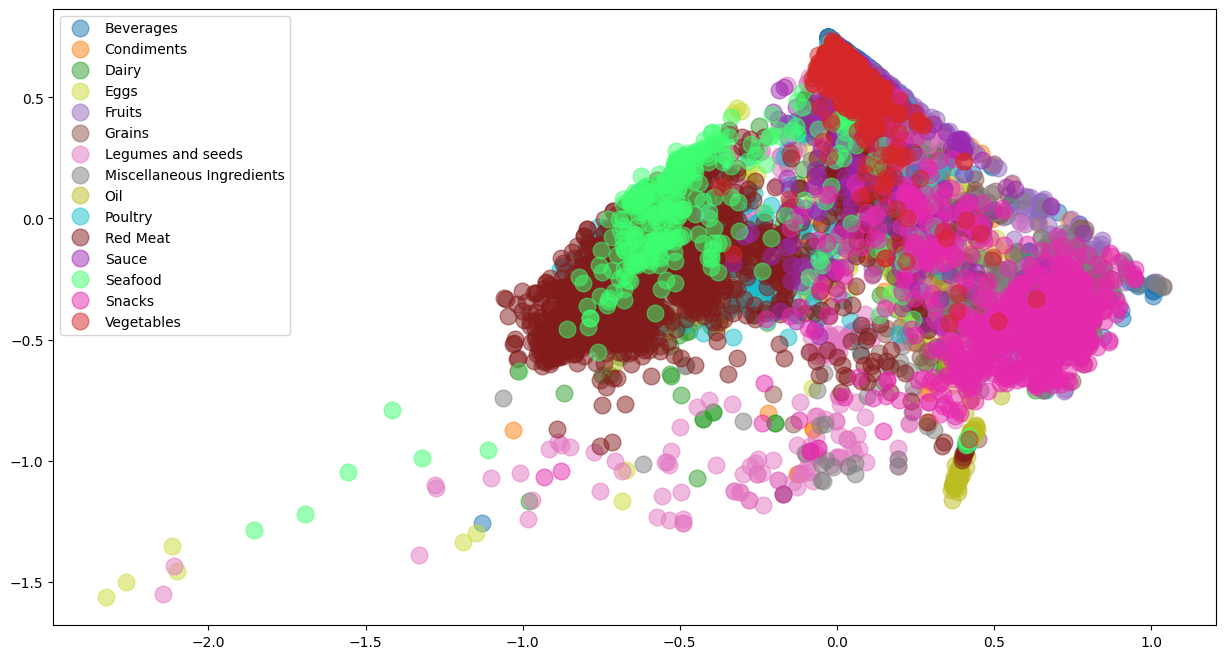

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Group data
groups = plt_df.groupby('category')

# Create a color map
colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#cddc39',   # Lime green
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-green
    '#17becf',  # Teal
    '#831b1b',  # Dark red
    '#9c27b0',  # Deep purple
    '#3dff6f',  # Light Green
    '#e629ad',  # Dark Pink
    '#d62728'  # Red
]

# Plot
fig, ax = plt.subplots(figsize=(15, 8))  # Adjust the size (width, height)
ax.margins(0.05)  # Optional, adds padding to the autoscaling

# Iterate through each group and assign a unique color
for (name, group), color in zip(groups, colors):
    ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=12, alpha=0.5, label=name, color=color)

ax.legend()
plt.show()